In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import json
from tqdm import tqdm
from typing import List
from scipy.spatial.distance import cosine, euclidean
from functools import partial
from sklearn.metrics import pairwise_distances
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc



In [3]:
#train_pairs=pd.read_parquet('dataset_ds/train_pairs.parquet') #
train_etl=pd.read_parquet('dataset_ds/train_data.parquet')
test_pairs = pd.read_parquet("dataset_ds/test_pairs_wo_target.parquet") #
test_etl = pd.read_parquet("dataset_ds/test_data.parquet")

#train_pairs=pd.read_parquet('health_train_iter1.parquet')
#train_adds=pd.read_parquet('new_pairs_w_target_iter2.parquet')
#train_adds2=pd.read_parquet('add_train_iter3.parquet')
#train_adds1=pd.read_parquet('train_adds_all_nr.parquet')
#train_adds=pd.read_parquet('train_adds_all.parquet')

train_pairs=pd.read_parquet('train_pairs_with_adds.parquet') # расширенный датасет





In [4]:
# пары теста есть в трейн выборке, а значит мы знаем ответ для них. запомним ответ
answer=test_pairs.merge(
    pd.concat([train_pairs,train_pairs.rename(columns={'variantid1':'variantid2','variantid2':'variantid1'})])
    .drop_duplicates(subset=['variantid1','variantid2']),
        on=['variantid1','variantid2'],how='left',suffixes=('','_1'))
answer=pd.DataFrame(answer[~answer['target'].isna()]).copy()
answer

,variantid1,variantid2,cat3_grouped,target
1035,246819473,481441652,"Смартфоны, планшеты, мобильные телефоны",0.0
1453,667246761,688358054,"Смартфоны, планшеты, мобильные телефоны",0.0
2430,186874171,527258028,Расходник для печати,0.0
2543,554977191,703443974,"Смартфоны, планшеты, мобильные телефоны",1.0
2766,563070850,588397077,Кабели и переходники,0.0
2810,623124310,672965259,Наушники и гарнитуры,1.0
3108,261788606,465201788,"Смартфоны, планшеты, мобильные телефоны",0.0
3147,92390514,615491224,Расходник для печати,0.0
3295,463679888,551014265,Компьютер,0.0
3365,369693751,599170053,Оптические приборы,1.0


In [5]:
# берём список категорий из теста чтобы задать что входит в категорию rest и какие категории остаются
cat3set=set(test_pairs['cat3_grouped'].unique().tolist())

In [6]:
# описание товаров в трейн и тест пересекаются по номерам и отличны по содержанию.
# заменим описание в тесте на описания из трейн выборки
diff_list=set(train_etl['variantid'].to_list()) & set(test_etl['variantid'].to_list())
test_etl.drop(test_etl[test_etl['variantid'].isin(diff_list)].index,axis=0,inplace=True)
all_etl=pd.concat([train_etl,test_etl],axis=0)

In [7]:
len(diff_list)

3021

In [13]:
# заполним признакb

In [14]:
# characteristic_attributes_mapping
features = (train_pairs.merge(all_etl[['variantid','characteristic_attributes_mapping']].add_suffix('1'),on="variantid1").merge(all_etl[['variantid','characteristic_attributes_mapping']].add_suffix('2'),on="variantid2"))


In [15]:
test_features = (test_pairs.merge(all_etl[['variantid','characteristic_attributes_mapping']].add_suffix('1'),on="variantid1").merge(all_etl[['variantid','characteristic_attributes_mapping']].add_suffix('2'),on="variantid2"))

In [16]:
def check_value_json1(_x1,_x2):  
    _d={}
    if _x1 is None:
        _d1=[]
    else:        
        _d1=json.loads(_x1)
    if _x2 is None:
        _d2=[]
    else:
        _d2=json.loads(_x2)
    _sd1=set(_d1)
    _sd2=set(_d2)
    
    for _s in _sd1.intersection(_sd2):           
        if len(set(_d1[_s]) ^ set(_d2[_s]))>0:
            _d[_s]=-1
        else:
            _d[_s]=1
    
        
    return _d

In [8]:
all=set()
for s in all_etl[~all_etl['characteristic_attributes_mapping'].isna()]['characteristic_attributes_mapping']:
    d = json.loads(s)    
    all=all.union(set(d))
  
len(all)

1461

In [18]:
all_etl['3_1']=all_etl['categories'].apply(lambda x:json.loads(x)["3"])
all_etl["cat3_grouped"] = all_etl["3_1"].apply(lambda x: x if (x in cat3set) else "rest")
features = features.merge(all_etl[['variantid','cat3_grouped']].add_suffix('1'),on="variantid1")
features.rename(columns={'cat3_grouped1':'cat3_grouped'},inplace=True)

In [20]:
features=pd.concat([features,
                    features[['characteristic_attributes_mapping1','characteristic_attributes_mapping2']].apply(lambda x: pd.Series(check_value_json1(x['characteristic_attributes_mapping1'],x['characteristic_attributes_mapping2']),dtype='Int8'),axis=1)],axis=1)
features.drop(['characteristic_attributes_mapping1','characteristic_attributes_mapping2'],axis=1,inplace=True)

features.fillna(0,inplace=True)

In [21]:
test_features=pd.concat([test_features,
                    test_features[['characteristic_attributes_mapping1','characteristic_attributes_mapping2']]
                    .apply(lambda x: pd.Series(check_value_json1(x['characteristic_attributes_mapping1'],x['characteristic_attributes_mapping2']),dtype='Int8'),axis=1)],axis=1)
test_features.drop(['characteristic_attributes_mapping1','characteristic_attributes_mapping2'],axis=1,inplace=True)

test_features.fillna(0,inplace=True)

In [22]:
len(features.columns.to_list())

1282

In [23]:
cols_to_test=all.difference(set(test_features.columns.to_list()))
test_features=pd.concat([test_features,pd.DataFrame(data=np.zeros(shape=(test_features.shape[0],len(cols_to_test))),columns=list(cols_to_test),dtype='Int8')],axis=1)

In [24]:
cols_to_test=all.difference(set(features.columns.to_list()))
features=pd.concat([features,pd.DataFrame(data=np.zeros(shape=(features.shape[0],len(cols_to_test))),columns=list(cols_to_test),dtype='Int8')],axis=1)

In [25]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18084 entries, 0 to 18083
Columns: 1464 entries, variantid1 to Насадки
dtypes: Int8(1461), int64(2), object(1)
memory usage: 50.9+ MB


# Name and main pic

In [26]:
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles: List[int]):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
    
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(
            main_pic_embeddings_1, main_pic_embeddings_2
        )
    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features


def text_dense_distances(ozon_embedding, comp_embedding):
    """Calculate Euclidean and Cosine distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        pair_features = [-1, -1]
    elif len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        pair_features = [-1, -1]
    else:
        pair_features.append(
            euclidean(ozon_embedding, comp_embedding)
        )
        cosine_value = cosine(ozon_embedding, comp_embedding)
        
        pair_features.append(cosine_value)

    return pair_features

def name_distances(name1, name2):
    """Calculate Euclidean and Cosine distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = 0
    if name1 is None or name2 is None:
        return 0
    if name1.lower()==name2.lower():
        return 1
    return -1

def main_pics_distances(ozon_embedding, comp_embedding):
    """Calculate Euclidean and Cosine distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        return [-1, -1, 0]
    
    ozon_embedding=ozon_embedding[0]
    comp_embedding=comp_embedding[0]
    if len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        return [-1, -1, 0]
    else:
        pair_features.append(euclidean(ozon_embedding, comp_embedding))        
        pair_features.append(cosine(ozon_embedding, comp_embedding))
        pair_features.append(1)

    return pair_features

In [27]:
features = (features.merge(all_etl[['variantid','name_bert_64','main_pic_embeddings_resnet_v1','name']].add_suffix('1'),on="variantid1").merge(all_etl[['variantid','name_bert_64','main_pic_embeddings_resnet_v1','name']].add_suffix('2'),on="variantid2"))

In [28]:
test_features = (test_features.merge(all_etl[['variantid','name_bert_64','main_pic_embeddings_resnet_v1','name']].add_suffix('1'),on="variantid1").merge(all_etl[['variantid','name_bert_64','main_pic_embeddings_resnet_v1','name']].add_suffix('2'),on="variantid2"))

In [29]:
features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)
features.drop(['name_bert_641','name_bert_642'],axis=1,inplace=True)

In [30]:
test_features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    test_features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)
test_features.drop(['name_bert_641','name_bert_642'],axis=1,inplace=True)

In [31]:
get_pic_features_func = partial(
    get_pic_features,
    percentiles=[0, 25, 50]
)

In [32]:
features[["cosine_main_pic_dist", "eu_mainpic_dist", "bl_main_pic"]] = (
    features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(main_pics_distances(*x)), axis=1
    )
)
features.drop(['main_pic_embeddings_resnet_v11','main_pic_embeddings_resnet_v12'],axis=1,inplace=True)

In [33]:
test_features[["cosine_main_pic_dist", "eu_mainpic_dist", "bl_main_pic"]] = (
    test_features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(main_pics_distances(*x)), axis=1
    )
)
test_features.drop(['main_pic_embeddings_resnet_v11','main_pic_embeddings_resnet_v12'],axis=1,inplace=True)

In [35]:
features['name_bl']=-1
features.loc[features['name1'].str.lower()==features['name2'].str.lower(),'name_bl']=1
features.drop(['name1','name2'],axis=1,inplace=True)

In [36]:
test_features['name_bl']=-1
test_features.loc[test_features['name1'].str.lower()==test_features['name2'].str.lower(),'name_bl']=1
test_features.drop(['name1','name2'],axis=1,inplace=True)

In [38]:
features = (features.merge(all_etl[['variantid','categories']].add_suffix('1'),on="variantid1").merge(all_etl[['variantid','categories']].add_suffix('2'),on="variantid2"))
features['2_1']=features['categories1'].apply(lambda x:json.loads(x)["2"])
features['3_1']=features['categories1'].apply(lambda x:json.loads(x)["3"])
features['4_1']=features['categories1'].apply(lambda x:json.loads(x)["4"])
features['2_2']=features['categories2'].apply(lambda x:json.loads(x)["2"])
features['3_2']=features['categories2'].apply(lambda x:json.loads(x)["3"])
features['4_2']=features['categories2'].apply(lambda x:json.loads(x)["4"])

features['2_bool']=1
features['3_bool']=1
features['4_bool']=1
features.loc[~(features['2_1']==features['2_2']),'2_bool']=-1
features.loc[~(features['3_1']==features['3_2']),'3_bool']=-1
features.loc[~(features['4_1']==features['4_2']),'4_bool']=-1
features.drop(['categories1','categories2'],axis=1,inplace=True)

In [39]:
test_features = (test_features.merge(all_etl[['variantid','categories']].add_suffix('1'),on="variantid1").merge(all_etl[['variantid','categories']].add_suffix('2'),on="variantid2"))
test_features['2_1']=test_features['categories1'].apply(lambda x:json.loads(x)["2"])
test_features['3_1']=test_features['categories1'].apply(lambda x:json.loads(x)["3"])
test_features['4_1']=test_features['categories1'].apply(lambda x:json.loads(x)["4"])
test_features['2_2']=test_features['categories2'].apply(lambda x:json.loads(x)["2"])
test_features['3_2']=test_features['categories2'].apply(lambda x:json.loads(x)["3"])
test_features['4_2']=test_features['categories2'].apply(lambda x:json.loads(x)["4"])

test_features['2_bool']=1
test_features['3_bool']=1
test_features['4_bool']=1
test_features.loc[~(test_features['2_1']==test_features['2_2']),'2_bool']=-1
test_features.loc[~(test_features['3_1']==test_features['3_2']),'3_bool']=-1
test_features.loc[~(test_features['4_1']==test_features['4_2']),'4_bool']=-1
test_features.drop(['categories1','categories2','3_1','3_2'],axis=1,inplace=True)

In [40]:

features.drop(['3_1','3_2'],axis=1,inplace=True)


In [41]:
features = (features.merge(all_etl[['variantid','pic_embeddings_resnet_v1']].add_suffix('1'),on="variantid1").merge(all_etl[['variantid','pic_embeddings_resnet_v1']].add_suffix('2'),on="variantid2"))
features[["apic_dist_0_perc", "apic_dist_25_perc", "apic_dist_50_perc"]] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)
features.drop(['pic_embeddings_resnet_v11','pic_embeddings_resnet_v12'],axis=1,inplace=True)

In [42]:
test_features = (test_features.merge(all_etl[['variantid','pic_embeddings_resnet_v1']].add_suffix('1'),on="variantid1").merge(all_etl[['variantid','pic_embeddings_resnet_v1']].add_suffix('2'),on="variantid2"))
test_features[["apic_dist_0_perc", "apic_dist_25_perc", "apic_dist_50_perc"]] = (
    test_features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)
test_features.drop(['pic_embeddings_resnet_v11','pic_embeddings_resnet_v12'],axis=1,inplace=True)

In [43]:
def color_distance(ozon_embedding, comp_embedding):
    """Calculate Euclidean and Cosine distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        return [0, 0]
    elif len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        pair_features = [0, 0]
    else:
        pair_features.append(
            len(set(ozon_embedding) & set(comp_embedding)) / max(len( comp_embedding),len( ozon_embedding))
        )
        if len(set(ozon_embedding) & set(comp_embedding))>0:
            cosine_value = 1
        else:
            cosine_value = -1
        
        pair_features.append(cosine_value)

    return pair_features

In [44]:
features = (features.merge(all_etl[['variantid','color_parsed']].add_suffix('1'),on="variantid1").merge(all_etl[['variantid','color_parsed']].add_suffix('2'),on="variantid2"))
features[["color_parsed1_dist", "color_parsed_dist"]] = (
    features[["color_parsed1", "color_parsed2"]].apply(
        lambda x: pd.Series(color_distance(*x)), axis=1
    )
)
features.drop(['color_parsed1','color_parsed2'],axis=1,inplace=True)

In [45]:
test_features = (test_features.merge(all_etl[['variantid','color_parsed']].add_suffix('1'),on="variantid1").merge(all_etl[['variantid','color_parsed']].add_suffix('2'),on="variantid2"))
test_features[["color_parsed1_dist", "color_parsed_dist"]] = (
    test_features[["color_parsed1", "color_parsed2"]].apply(
        lambda x: pd.Series(color_distance(*x)), axis=1
    )
)
test_features.drop(['color_parsed1','color_parsed2'],axis=1,inplace=True)

In [10]:

all_features_for_model = features.drop(['variantid1','variantid2','target'],axis=1).columns.tolist() 
features.duplicated(subset=all_features_for_model).sum()

68842

In [11]:
features.drop_duplicates(subset=all_features_for_model,inplace=True)

In [12]:
all_features_for_model = features.drop(['variantid1','variantid2','target'],axis=1).columns.tolist() 

In [13]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
target_col='target'

In [9]:

#features.to_parquet('train_for_model_default.parquet') #ready to train
#test_features.to_parquet('test_for_model_default.parquet') #ready to test

#test_features.to_parquet('test_for_model_default_1.parquet') #ready to test
#features.to_parquet('train_for_model_iter1_1.parquet') #ready to train

test_features=pd.read_parquet('test_for_model_default_1.parquet') 
features=pd.read_parquet('train_for_model_iter1_1.parquet') 
#features=pd.read_parquet('train_for_model_default.parquet') 
#test_features=pd.read_parquet('test_for_model_default.parquet')

In [14]:
x_train, x_test, y_train, y_test = train_test_split(features, features[target_col], test_size = 0.5, random_state = 15,stratify=features[target_col])

In [15]:

cat_feature=['4_1','4_2','2_1','2_2','cat3_grouped']

train_pool = Pool(data=x_train.drop(['variantid1','variantid2',target_col],axis=1), label=y_train,cat_features=cat_feature)
valid_pool = Pool(data=x_test.drop(['variantid1','variantid2',target_col],axis=1), label=y_test,cat_features=cat_feature)



In [16]:

clf = CatBoostClassifier(task_type='GPU', iterations=3000,learning_rate=0.15, depth=7, verbose=300, random_state = 6) 
clf.fit(train_pool, eval_set=valid_pool, verbose = 300,early_stopping_rounds=100) 



0:	learn: 0.6456759	test: 0.6457120	best: 0.6457120 (0)	total: 55.7ms	remaining: 2m 46s
300:	learn: 0.4356284	test: 0.4534034	best: 0.4534034 (300)	total: 13.2s	remaining: 1m 57s
600:	learn: 0.4154601	test: 0.4482818	best: 0.4482818 (600)	total: 26.1s	remaining: 1m 44s
900:	learn: 0.4006839	test: 0.4462447	best: 0.4462447 (900)	total: 38.9s	remaining: 1m 30s
1200:	learn: 0.3871856	test: 0.4450538	best: 0.4450450 (1198)	total: 51.7s	remaining: 1m 17s
1500:	learn: 0.3751314	test: 0.4444313	best: 0.4444267 (1498)	total: 1m 4s	remaining: 1m 4s
bestTest = 0.4442470298
bestIteration = 1595
Shrink model to first 1596 iterations.


In [17]:
clf1 = CatBoostClassifier(task_type='GPU', iterations=3000,learning_rate=0.15, depth=7, verbose=300, random_state = 6) 
clf1.fit(valid_pool, eval_set=train_pool, verbose = 300,early_stopping_rounds=100) 

0:	learn: 0.6465197	test: 0.6463833	best: 0.6463833 (0)	total: 45.6ms	remaining: 2m 16s
300:	learn: 0.4366319	test: 0.4523419	best: 0.4523419 (300)	total: 12.8s	remaining: 1m 54s
600:	learn: 0.4158392	test: 0.4467201	best: 0.4467201 (600)	total: 25.4s	remaining: 1m 41s
900:	learn: 0.3999708	test: 0.4441808	best: 0.4441808 (900)	total: 38.2s	remaining: 1m 28s
1200:	learn: 0.3866719	test: 0.4430725	best: 0.4430681 (1199)	total: 51.4s	remaining: 1m 17s
1500:	learn: 0.3743537	test: 0.4424292	best: 0.4424192 (1490)	total: 1m 4s	remaining: 1m 4s
bestTest = 0.4423912305
bestIteration = 1517
Shrink model to first 1518 iterations.


In [23]:
clf_final1 = CatBoostClassifier(task_type='GPU', iterations=1500,learning_rate=0.15, depth=7, verbose=300, random_state = 6) 
clf_final1.fit(features.drop(['variantid1','variantid2',target_col],axis=1),features[target_col],cat_features=cat_feature, verbose = 300) 

0:	learn: 0.6457548	total: 212ms	remaining: 5m 17s
300:	learn: 0.4412471	total: 18.1s	remaining: 1m 11s
600:	learn: 0.4259041	total: 35.9s	remaining: 53.7s
900:	learn: 0.4147000	total: 53.1s	remaining: 35.3s
1200:	learn: 0.4056135	total: 1m 10s	remaining: 17.6s
1499:	learn: 0.3972368	total: 1m 28s	remaining: 0us


In [25]:
features['cat3_grouped'].value_counts()

Смартфоны, планшеты, мобильные телефоны       54175
Компьютер                                     48201
Расходник для печати                          23839
Чехол                                         23830
Кабели и переходники                          20744
Смарт-часы                                    13266
Наушники и гарнитуры                          12778
Устройство ручного ввода                      10742
Зарядные устройства и док-станции              9976
rest                                           9146
Видеонаблюдение                                8965
Материнская плата                              8639
Батарейки и аккумуляторы                       7992
Запчасти для ноутбуков                         7289
Запчасти для смартфонов                        7019
Жесткие диски, SSD и сетевые накопители        6731
Защитные пленки и стекла                       5275
Оптические приборы                             5188
Телевизоры                                     3804
Видеокарты и

In [ ]:
iters=[]
models=[]
best_score_models_learn=[]
best_score_models_val=[]
category_list=[]
for _cat in cat3set: 
    print(_cat)
    _data=features[features['cat3_grouped']==_cat]
    x_train, x_test, y_train, y_test = train_test_split(_data, _data[target_col], test_size = 0.2, random_state = 15,stratify=_data[target_col])
    cat_feature=['4_1','4_2','2_1','2_2']
    clf2 = CatBoostClassifier(task_type='GPU', iterations=5000,learning_rate=0.1, depth=7, verbose=300, random_state = 6) 
    clf2.fit(x_train.drop(['variantid1','variantid2','cat3_grouped',target_col],axis=1),y_train, eval_set=(x_test.drop(['variantid1','variantid2','cat3_grouped',target_col],axis=1),y_test),cat_features=cat_feature, verbose = 300,early_stopping_rounds=100)
    iters.append(clf2.get_best_iteration())
    models.append(clf2)
    best_score_models_learn.append(clf2.get_best_score()['learn']['Logloss'])
    best_score_models_val.append(clf2.get_best_score()['validation']['Logloss'])
    category_list.append(_cat)




In [28]:
ii=0
models=[]
best_score_models_learn=[]
for _cat in cat3set: 
    print(_cat)
    if category_list[ii]!=_cat:
        print(_cat,category_list[ii],ii)

    _data=features[features['cat3_grouped']==_cat]    
    cat_feature=['4_1','4_2','2_1','2_2']
    clf2 = CatBoostClassifier(task_type='GPU', iterations=iters[ii],learning_rate=0.1, depth=7, verbose=300, random_state = 6) 
    clf2.fit(_data.drop(['variantid1','variantid2','cat3_grouped',target_col],axis=1),_data[target_col],cat_features=cat_feature, verbose = 300)    
    models.append(clf2)
    best_score_models_learn.append(clf2.get_best_score()['learn']['Logloss'])    
    ii+=1

Наушники и гарнитуры
0:	learn: 0.6321374	total: 24.5ms	remaining: 6.26s
256:	learn: 0.2499902	total: 6.17s	remaining: 0us
Оптические приборы
0:	learn: 0.6467863	total: 24.5ms	remaining: 7.41s
300:	learn: 0.2060020	total: 6.74s	remaining: 67.2ms
303:	learn: 0.2045055	total: 6.81s	remaining: 0us
Аксессуары для фото и видеотехники
0:	learn: 0.6262375	total: 13.6ms	remaining: 1.03s
76:	learn: 0.2301237	total: 944ms	remaining: 0us
Расходник для печати
0:	learn: 0.6627324	total: 25ms	remaining: 5.67s
227:	learn: 0.4311792	total: 5.8s	remaining: 0us
Батарейки и аккумуляторы
0:	learn: 0.6491272	total: 27.6ms	remaining: 9.84s
300:	learn: 0.2868377	total: 7.72s	remaining: 1.44s
356:	learn: 0.2685101	total: 9.2s	remaining: 0us
Микрофоны и аксессуары
0:	learn: 0.6300457	total: 13.6ms	remaining: 463ms
34:	learn: 0.2907825	total: 453ms	remaining: 0us
Смарт-часы
0:	learn: 0.6589491	total: 61.4ms	remaining: 32.4s
300:	learn: 0.4434759	total: 15.9s	remaining: 12s
527:	learn: 0.4361302	total: 27.1s	rema

In [ ]:
clf.get_feature_importance(valid_pool,prettified=True).head(20)

In [320]:
metrics = clf.eval_metrics(valid_pool, ['MCC', 'F1', 'Recall'])
for metric, values in metrics.items():
    print(f'{metric}: {values[-1]}')

MCC: 0.6015214309645822
F1: 0.7833102162888476
Recall: 0.7997942068110907


In [16]:
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(df): 

    #df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])

    y_true = df["target"]
    y_pred = df["scores"]
    _categories = df["cat3_grouped"]
    prec_level=0.75

    weights = []
    pr_aucs = []
    res=dict()

    unique_cats, counts = np.unique(_categories, return_counts=True)
    res['name']=unique_cats
    res['len']=counts
    
    # calculate metric for each big category
    for i, _category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(_categories == _category)[0]
        y_pred_cat = y_pred.iloc[cat_idx]
        y_true_cat = y_true.iloc[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(_categories))
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(counts[i] / len(_categories))
            continue
        
        # calculate category weight anyway
        weights.append(counts[i] / len(_categories))
        
        
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                
        except ValueError:
            pr_aucs.append(0)
            
    #return np.average(pr_aucs, weights=weights)
    res['aucs']=pr_aucs
    res['weights']=weights

    return pr_aucs, weights,res


In [17]:
x_test["scores"] = clf.predict_proba(x_test.drop(['variantid1','variantid2',target_col],axis=1))[:, 1]

In [136]:
ii=0
features['scores']=0
for _cat in cat3set:     
    _data=features[features['cat3_grouped']==_cat]
    features.loc[features['cat3_grouped']==_cat,'scores']=models[ii].predict_proba(features[features['cat3_grouped']==_cat].drop(['variantid1','variantid2',target_col,'cat3_grouped','scores'],axis=1))[:, 1]

    ii+=1

In [ ]:
x_train["scores"] = clf1.predict_proba(x_train.drop(['variantid1','variantid2',target_col],axis=1))[:, 1]

In [137]:
auc_res, weights,res_dict = pr_auc_macro(features[['variantid1','variantid2',target_col,'scores','cat3_grouped']].copy())

In [119]:
auc_res, weights,res_dict = pr_auc_macro(x_train[['variantid1','variantid2',target_col,'scores','cat3_grouped']].copy())

In [35]:
auc_res, weights,res_dict = pr_auc_macro(x_test[['variantid1','variantid2',target_col,'scores','cat3_grouped']].copy())

In [120]:
np.average(auc_res, weights=weights)

0.49404073129853626

In [138]:
result2=pd.DataFrame(res_dict,columns=res_dict.keys())

In [36]:
results = pd.DataFrame(res_dict,columns=res_dict.keys())

In [139]:
results=results.merge(result2,on='name',how='left',suffixes=('','_2'))

In [143]:
#results.to_csv('results_val.csv')

In [37]:
results.sort_values('aucs',ascending=True)

,name,len,aucs,weights
7,Компьютер,9745,0.004327,0.222687
13,Электронные модули,730,0.093200,0.016682
0,Запчасти для аудио/видеотехники,105,0.142424,0.002399
4,Защитные пленки и стекла,1079,0.183984,0.024657
1,Запчасти для ноутбуков,1503,0.274952,0.034346
3,Зарядные устройства и док-станции,2056,0.287772,0.046982
2,Запчасти для смартфонов,1436,0.324129,0.032815
8,Материнская плата,1691,0.400719,0.038642
12,Чехол,4683,0.454290,0.107013
9,Оперативная память,512,0.496076,0.011700


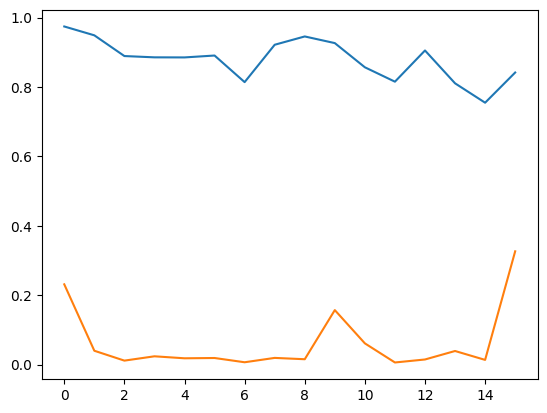

In [332]:
plt.plot(results.aucs)
plt.plot(results.weights)

In [ ]:
clf.get_all_params()

In [70]:
print(classification_report(x_test[target_col], x_test["scores"]>0.5))

              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81    110132
         1.0       0.84      0.87      0.85    136625

    accuracy                           0.83    246757
   macro avg       0.83      0.83      0.83    246757
weighted avg       0.83      0.83      0.83    246757



0.8900508279132393


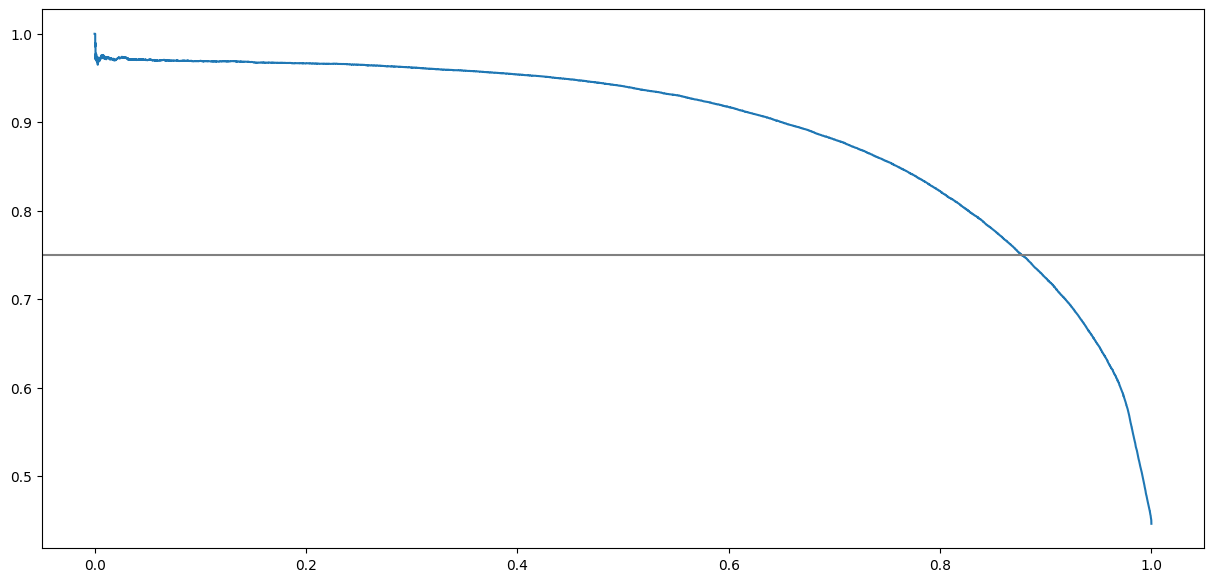

In [68]:
precision, recall, thrs = precision_recall_curve(x_train[target_col]==0, 1-x_train["scores"])
#precision1, recall1, thrs1 = precision_recall_curve(x_test[target_col], x_test["scores_max"])
pr_auc = auc(recall, precision)
print(pr_auc)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
#ax1.plot(recall1, precision1)
ax1.axhline(y=0.75, color='grey', linestyle='-');

SUBMISSION

In [29]:
ii=0

for _cat in cat3set:     
    if best_score_models_learn[ii]<0.45:
        test_features.loc[test_features['cat3_grouped']==_cat,'target_cat']=models[ii].predict_proba(test_features[test_features['cat3_grouped']==_cat][all_features_for_model].drop(['cat3_grouped'],axis=1))[:, 1]

    ii+=1

In [30]:
test_features["target1"] = clf.predict_proba(test_features[all_features_for_model])[:, 1]

In [31]:
test_features["target2"] = clf1.predict_proba(test_features[all_features_for_model])[:, 1]

In [32]:
test_features['target1']=(test_features['target1']+test_features['target2'])/2

In [35]:
test_features['target']=clf_final1.predict_proba(test_features[all_features_for_model])[:, 1]

In [95]:
test_features["target2"] = clf_final1.predict_proba(test_features[all_features_for_model])[:, 1]

In [66]:
test_features.drop(['target_cat'],axis=1,inplace=True)

In [41]:
test_features[~test_features['target_answer'].isna()][['target','target1','target_cat','target_answer','cat3_grouped']]

,target,target1,target_cat,target_answer,cat3_grouped
1069,0.0,0.039910,0.012289,0.0,"Смартфоны, планшеты, мобильные телефоны"
1501,0.0,0.052322,0.043381,0.0,"Смартфоны, планшеты, мобильные телефоны"
2508,0.0,0.652167,0.413552,0.0,Расходник для печати
2625,1.0,0.362964,0.322175,1.0,"Смартфоны, планшеты, мобильные телефоны"
2856,0.0,0.054825,0.053263,0.0,Кабели и переходники
2902,1.0,0.860705,0.810319,1.0,Наушники и гарнитуры
3209,0.0,0.234507,0.175351,0.0,"Смартфоны, планшеты, мобильные телефоны"
3248,0.0,0.068822,0.020156,0.0,Расходник для печати
3400,0.0,0.106545,0.110693,0.0,Компьютер
3472,1.0,0.545176,0.615369,1.0,Оптические приборы


In [39]:
test_features.loc[~test_features['target_cat'].isna(),'target']=test_features.loc[~test_features['target_cat'].isna(),'target_cat']

In [40]:
test_features.loc[~test_features['target_answer'].isna(),'target']=test_features.loc[~test_features['target_answer'].isna(),'target_answer']

In [28]:
test_features.drop(['target_answer','target1','target2'],axis=1,inplace=True)

In [34]:
test_features=test_features.merge(answer,on=['variantid1','variantid2'],how='left',suffixes=('','_answer'))
test_features.loc[~test_features['target_answer'].isna(),'target']=test_features.loc[~test_features['target_answer'].isna(),'target_answer']

In [85]:
test_features[['variantid1','variantid2','target']].to_csv('submission_last.csv',index=False)